# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Setup](#Setup)
* [Evaluate](#Evaluate)
* [Results](#Results)
* [Discussion](#Discussion)

# Introduction

Feature engineering could continue ad infinitum. Any classifier that implements .predict_proba can generate per-class features that could be useful (calibration can enable predict_proba for models that don't natively implement). These probabilities are all new features. And then two LDA components can be extracted from each of these trios. What's more, you could select any intermediate stage of feature extraction and generate more predicted probabilities or components. And don't forget we have the original FRILL features to tinker with too!

This approach will be limited by how good the FRILL embeddings are without returning to the raw signal. As such, it is worth it to produce such features using the most performant models, as we did with SVM.

This notebook examines the efficacy of bespoke FRILL-based features with GaussianNB. The grid distributions are narrowed from previous findings. This notebook also re-introduces the use of the Brier score loss, which is a proper scoring metric.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [29]:
# core
import numpy as np
import pandas as pd

# utility
from copy import deepcopy
from datetime import date
from gc import collect as gc_collect
from json import dumps

# from tempfile import TemporaryDirectory
from tqdm.notebook import tqdm

# typing
from typing import List

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# metrics
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    log_loss,
    roc_auc_score,
)

# other sklearn
from sklearn.feature_selection import (
    f_classif,
    mutual_info_classif,
    SelectFromModel,
    SelectKBest,
)
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

# param distributions
from scipy.stats import loguniform, uniform

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

time: 4.02 ms


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
# Location of cross validation data
FEATURES_FOLDER = "../10.0-mic-prepare_train-test_splits_on_full_data"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 104 ms


# Setup

In this section, we define some structures to keep track of models and scores.

In [5]:
FOLDS = (0, 1, 2, 3, 4)

SCORERS = {
    "accuracy": accuracy_score,
    "adjusted_balanced_accuracy": lambda y_true, y_pred: balanced_accuracy_score(
        y_true, y_pred, adjusted=True
    ),
    "f1_weighted": lambda y_true, y_pred: f1_score(y_true, y_pred, average="weighted"),
    "geometric_mean": geometric_mean_score,
    # probabilities required below
    "log_loss": log_loss,
    "roc_auc_ovo": lambda y_true, y_pred: roc_auc_score(
        y_true, y_pred, multi_class="ovo"
    ),
}

_ = gc_collect()

time: 105 ms


In [6]:
# make_pipeline = lambda temp_dir: Pipeline(
make_pipeline = lambda: Pipeline(
    steps=[
        ("select_features", "passthrough"),
        ("clf", "passthrough"),
    ],
    # memory=temp_dir,
    verbose=True,
)

plain_grid = lambda: {
    "clf": [GaussianNB()],
    "clf__var_smoothing": loguniform(1e-20, 1.1),
}

bagging_grid = lambda: {
    "clf": [
        BaggingClassifier(
            base_estimator=GaussianNB(),
            n_jobs=-1,
            random_state=SEED,
            verbose=1,
        )
    ],
    "clf__n_estimators": list(range(2, 21)),
    "clf__max_samples": uniform(0.5, 0.5),
    "clf__max_features": uniform(0.5, 0.5),
    "clf__base_estimator__var_smoothing": loguniform(1e-20, 1.1),
}

selectkbest_grid = lambda: {
    "select_features": [SelectKBest()],
    "select_features__score_func": [f_classif, mutual_info_classif],
    "select_features__k": list(range(2, 20)),
}

# selectkbest_f_grid = lambda: {
#     "select_features": [SelectKBest(score_func=f_classif)],
#     "select_features__k": list(range(2, 20)),
# }
# selectkbest_mi_grid = lambda: {
#     "select_features": [SelectKBest(score_func=mutual_info_classif)],
#     "select_features__k": list(range(2, 20)),
# }

adaboost_dtree_select_grid = lambda: {
    "select_features": [
        SelectFromModel(
            estimator=AdaBoostClassifier(
                base_estimator=DecisionTreeClassifier(random_state=SEED),
                random_state=SEED,
            ),
            max_features=20,
        )
    ],
    "select_features__estimator__n_estimators": list(range(3, 61)),
    "select_features__estimator__learning_rate": loguniform(1e-20, 10.0),
    "select_features__estimator__base_estimator__splitter": ["best", "random"],
    "select_features__estimator__base_estimator__criterion": ["gini", "entropy"],
    "select_features__estimator__base_estimator__max_depth": list(range(1, 6)),
    "select_features__estimator__base_estimator__min_samples_split": list(range(2, 21)),
    "select_features__estimator__base_estimator__min_samples_leaf": list(range(1, 21)),
    "select_features__estimator__base_estimator__min_weight_fraction_leaf": uniform(
        0.0, 0.5
    ),
    "select_features__estimator__base_estimator__max_features": ["sqrt", "log2"],
    "select_features__estimator__base_estimator__max_leaf_nodes": list(range(2, 51)),
    "select_features__estimator__base_estimator__min_impurity_decrease": uniform(
        0.0, 0.5
    ),
    "select_features__estimator__base_estimator__class_weight": [None, "balanced"],
    "select_features__estimator__base_estimator__ccp_alpha": loguniform(1e-20, 0.25),
}

# adaboost_extratrees_select_grid = lambda: {
#     "select_features": [
#         SelectFromModel(
#             estimator=AdaBoostClassifier(
#                 base_estimator=ExtraTreesClassifier(random_state=SEED, verbose=1),
#                 random_state=SEED,
#             ),
#             max_features=20,
#         )
#     ],
#     "select_features__estimator__n_estimators": list(range(3, 51)),
#     "select_features__estimator__learning_rate": loguniform(1e-20, 10.0),
#     "select_features__estimator__base_estimator__n_estimators": list(range(3, 101)),
#     "select_features__estimator__base_estimator__criterion": ["gini", "entropy"],
#     "select_features__estimator__base_estimator__max_depth": list(range(1, 11)),
#     "select_features__estimator__base_estimator__min_samples_split": list(range(2, 21)),
#     "select_features__estimator__base_estimator__min_samples_leaf": list(range(2, 21)),
#     "select_features__estimator__base_estimator__min_weight_fraction_leaf": loguniform(
#         1e-50, 0.5
#     ),
#     "select_features__estimator__base_estimator__max_features": [
#         "sqrt",
#         "log2",
#     ],
#     "select_features__estimator__base_estimator__max_leaf_nodes": list(range(2, 51)),
#     "select_features__estimator__base_estimator__min_impurity_decrease": uniform(
#         0.0, 0.5
#     ),
#     "select_features__estimator__base_estimator__bootstrap": [False, True],
#     "select_features__estimator__base_estimator__class_weight": [
#         None,
#         "balanced",
#         "balanced_subsample",
#     ],
#     "select_features__estimator__base_estimator__ccp_alpha": loguniform(1e-20, 0.25),
#     "select_features__estimator__base_estimator__max_samples": uniform(0.5, 0.5),
# }

distributions = lambda: [
    # {
    #     **selectkbest_f_grid(),
    #     **plain_grid(),
    # },
    # {
    #     **selectkbest_mi_grid(),
    #     **plain_grid(),
    # },
    # {
    #     **selectkbest_f_grid(),
    #     **bagging_grid(),
    # },
    # {
    #     **selectkbest_mi_grid(),
    #     **bagging_grid(),
    # },
    {
        **selectkbest_grid(),
        **plain_grid(),
    },
    {
        **selectkbest_grid(),
        **bagging_grid(),
    },
    {
        **adaboost_dtree_select_grid(),
        **plain_grid(),
    },
    # {
    #     **adaboost_extratrees_select_grid(),
    #     **plain_grid(),
    # },
    {
        **adaboost_dtree_select_grid(),
        **bagging_grid(),
    },
    # {
    #     **adaboost_extratrees_select_grid(),
    #     **bagging_grid(),
    # },
]

_ = gc_collect()

time: 128 ms


# Evaluate

In [7]:
already_completed: List[int] = []
results = {
    "fold_num": [],
    "steps": [],
    "fit_time": [],
    "predict_time": [],
    **{key: [] for key in SCORERS.keys()},
}
for fold_num in tqdm(FOLDS):
    if fold_num in already_completed:
        continue
    fold_begin = time()

    read_feather = lambda filename: pd.read_feather(
        f"{FEATURES_FOLDER}/cv_{fold_num}/{filename}.feather"
    )

    # with TemporaryDirectory() as temp_dir:
    hypersearch = RandomizedSearchCV(
        # estimator=make_pipeline(temp_dir),
        estimator=make_pipeline(),
        param_distributions=distributions(),
        n_iter=101,
        scoring="neg_log_loss",
        n_jobs=-1,
        refit=True,
        verbose=2,
        random_state=SEED,
        error_score="raise",
    )

    X_train = read_feather("X_train_FRILL-based_uniQT")
    y_train = read_feather("y_train_untransformed").iloc[:, 0]

    # fit
    print("fitting hypersearch...")
    begin = time()
    hypersearch.fit(X_train, y_train)
    end = time()
    results["fit_time"].append(end - begin)

    # save CV results
    df = pd.DataFrame(hypersearch.cv_results_)
    convert_to_string = [
        key
        for key in (
            "param_clf",
            "param_select_features",
            "param_select_features__score_func",
            "params",
        )
        if key in df.columns
    ]  # convert unserializable object columns to str
    df.loc[:, convert_to_string] = df.loc[:, convert_to_string].astype(str)
    df["fold_num"] = fold_num
    df.to_feather(
        f"{DATA_OUT_FOLDER}/cv_{fold_num}_results/GaussianNB3_hypersearch.feather"
    )
    del convert_to_string
    del df
    _ = gc_collect()

    # log parameters
    with open(
        f"{DATA_OUT_FOLDER}/cv_{fold_num}_results/GaussianNB3_hypersearched_params.tsv",
        "a",
    ) as f:
        f.write(
            "\t".join(
                [
                    f"{date.today().isoformat()}",
                    f"{time()}",
                    f"{dumps(hypersearch.best_params_, default=str)}",
                    str(hypersearch.best_score_),
                    f"{fold_num}\n",
                ]
            )
        )

    # log retained features
    print(
        "features retained:",
        features := hypersearch.best_estimator_.named_steps[
            "select_features"
        ].get_feature_names_out(),
    )
    with open(
        f"{DATA_OUT_FOLDER}/cv_{fold_num}_results/GaussianNB3_features_retained.tsv",
        "a",
    ) as f:
        f.write(
            "\t".join(
                [
                    str(fold_num),
                    steps := str(hypersearch.best_estimator_.steps),
                    f"{features}\n",
                ]
            )
        )
    del features
    _ = gc_collect()

    # read test data
    X_test = read_feather("X_test_FRILL-based_uniQT")
    y_test = read_feather("y_test_untransformed").iloc[:, 0]
    del read_feather
    _ = gc_collect()

    # predict
    print("predicting...")
    begin = time()
    y_pred = hypersearch.predict(X_test)
    end = time()
    results["predict_time"].append(end - begin)
    del begin
    del end
    _ = gc_collect()
    proba_predict = hypersearch.predict_proba(X_test)

    del hypersearch
    _ = gc_collect()

    # save predictions
    pred_df = pd.DataFrame(proba_predict)
    pred_df.columns = pred_df.columns.astype(str)
    pred_df.to_feather(
        f"{DATA_OUT_FOLDER}/cv_{fold_num}_results/predictions_GaussianNB3.feather"
    )
    del pred_df
    _ = gc_collect()

    # score model
    results["fold_num"].append(fold_num)
    results["steps"].append(steps)
    del steps
    _ = gc_collect()

    print("evaluating...")
    for scorer in SCORERS:
        results[scorer].append(
            score := SCORERS[scorer](
                y_test,
                proba_predict if scorer in ["log_loss", "roc_auc_ovo"] else y_pred,
            )
        )  # roc_auc & log_loss needs probabilities
        print(f"{scorer}: {score:.3f}")
    del y_pred
    del proba_predict
    del score
    _ = gc_collect()

    # checkpoint fold results
    pd.DataFrame(results).to_feather(
        f"{DATA_OUT_FOLDER}/cv_{fold_num}_results/GaussianNB3_results.feather"
    )
    del X_train
    del X_test
    del y_train
    del y_test
    _ = gc_collect()

    print(f"fold {fold_num} completed in {time() - fold_begin:.2f} seconds")
    del fold_begin
    _ = gc_collect()

  0%|          | 0/5 [00:00<?, ?it/s]

fitting hypersearch...
Fitting 5 folds for each of 101 candidates, totalling 505 fits
[Pipeline] ... (step 1 of 2) Processing select_features, total= 5.4min
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.0s


RandomizedSearchCV(error_score='raise',
                   estimator=Pipeline(steps=[('select_features', 'passthrough'),
                                             ('clf', 'passthrough')],
                                      verbose=True),
                   n_iter=101, n_jobs=-1,
                   param_distributions=[{'clf': [GaussianNB(var_smoothing=0.8348538910338222)],
                                         'clf__var_smoothing': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001680BD75250>,
                                         'select_features': [Select...
                                         'select_features__estimator__base_estimator__splitter': ['best',
                                                                                                  'random'],
                                         'select_features__estimator__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001680BD80CD0>,
                               

380

features retained: ['theta_QT-norm_poly6_LDA1+poly6_LDA2' 'spherical-LDA1' 'spherical-LDA2'
 'OC_spherical-LDA_neg']


272

predicting...
evaluating...
accuracy: 0.659
adjusted_balanced_accuracy: 0.357
f1_weighted: 0.635
geometric_mean: 0.499
log_loss: 0.885
roc_auc_ovo: 0.765
fold 0 completed in 6811.54 seconds
fitting hypersearch...
Fitting 5 folds for each of 101 candidates, totalling 505 fits
[Pipeline] ... (step 1 of 2) Processing select_features, total= 4.9min
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.0s


RandomizedSearchCV(error_score='raise',
                   estimator=Pipeline(steps=[('select_features', 'passthrough'),
                                             ('clf', 'passthrough')],
                                      verbose=True),
                   n_iter=101, n_jobs=-1,
                   param_distributions=[{'clf': [GaussianNB(var_smoothing=0.8348538910338222)],
                                         'clf__var_smoothing': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001680BE07BE0>,
                                         'select_features': [Select...
                                         'select_features__estimator__base_estimator__splitter': ['best',
                                                                                                  'random'],
                                         'select_features__estimator__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001680BDE2A60>,
                               

379

features retained: ['theta_QT-norm_poly6_LDA1+poly6_LDA2' 'spherical-LDA1' 'spherical-LDA2'
 'OC_spherical-LDA_neg']


272

predicting...
evaluating...
accuracy: 0.644
adjusted_balanced_accuracy: 0.353
f1_weighted: 0.635
geometric_mean: 0.540
log_loss: 0.840
roc_auc_ovo: 0.781
fold 1 completed in 6730.19 seconds
fitting hypersearch...
Fitting 5 folds for each of 101 candidates, totalling 505 fits
[Pipeline] ... (step 1 of 2) Processing select_features, total= 4.4min
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.0s


RandomizedSearchCV(error_score='raise',
                   estimator=Pipeline(steps=[('select_features', 'passthrough'),
                                             ('clf', 'passthrough')],
                                      verbose=True),
                   n_iter=101, n_jobs=-1,
                   param_distributions=[{'clf': [GaussianNB(var_smoothing=0.8348538910338222)],
                                         'clf__var_smoothing': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001680C5B6DC0>,
                                         'select_features': [Select...
                                         'select_features__estimator__base_estimator__splitter': ['best',
                                                                                                  'random'],
                                         'select_features__estimator__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001680C5B6910>,
                               

379

features retained: ['theta_QT-norm_poly6_LDA1+poly6_LDA2' 'spherical-LDA1' 'spherical-LDA2'
 'OC_spherical-LDA_neg']


272

predicting...
evaluating...
accuracy: 0.595
adjusted_balanced_accuracy: 0.316
f1_weighted: 0.585
geometric_mean: 0.502
log_loss: 0.956
roc_auc_ovo: 0.744
fold 2 completed in 5951.18 seconds
fitting hypersearch...
Fitting 5 folds for each of 101 candidates, totalling 505 fits
[Pipeline] ... (step 1 of 2) Processing select_features, total= 3.9min
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.0s


RandomizedSearchCV(error_score='raise',
                   estimator=Pipeline(steps=[('select_features', 'passthrough'),
                                             ('clf', 'passthrough')],
                                      verbose=True),
                   n_iter=101, n_jobs=-1,
                   param_distributions=[{'clf': [GaussianNB(var_smoothing=0.00010248874577879313)],
                                         'clf__var_smoothing': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001680BD2A9D0>,
                                         'select_features': [Se...
                                         'select_features__estimator__base_estimator__splitter': ['best',
                                                                                                  'random'],
                                         'select_features__estimator__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001680BE05DF0>,
                               

387

features retained: ['spherical-LDA1' 'spherical-LDA2']


214

predicting...
evaluating...
accuracy: 0.607
adjusted_balanced_accuracy: 0.280
f1_weighted: 0.583
geometric_mean: 0.449
log_loss: 2.018
roc_auc_ovo: 0.729
fold 3 completed in 5239.56 seconds
fitting hypersearch...
Fitting 5 folds for each of 101 candidates, totalling 505 fits
[Pipeline] ... (step 1 of 2) Processing select_features, total= 4.4min
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.0s


RandomizedSearchCV(error_score='raise',
                   estimator=Pipeline(steps=[('select_features', 'passthrough'),
                                             ('clf', 'passthrough')],
                                      verbose=True),
                   n_iter=101, n_jobs=-1,
                   param_distributions=[{'clf': [GaussianNB(var_smoothing=0.8348538910338222)],
                                         'clf__var_smoothing': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001680BE038B0>,
                                         'select_features': [Select...
                                         'select_features__estimator__base_estimator__splitter': ['best',
                                                                                                  'random'],
                                         'select_features__estimator__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001680BE66340>,
                               

379

features retained: ['theta_QT-norm_poly6_LDA1+poly6_LDA2' 'spherical-LDA1' 'spherical-LDA2'
 'OC_spherical-LDA_neg']


272

predicting...
evaluating...
accuracy: 0.588
adjusted_balanced_accuracy: 0.321
f1_weighted: 0.574
geometric_mean: 0.498
log_loss: 0.971
roc_auc_ovo: 0.744
fold 4 completed in 6166.65 seconds
time: 8h 34min 59s


# Results

In [8]:
# full display of rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)
_ = gc_collect()

time: 130 ms


In [44]:
catcols = [
    f"param_{catcol}"
    for catcol in (
        "clf",
        "select_features",
        # "select_features__estimator",
        "select_features__estimator__base_estimator__class_weight",
        "select_features__estimator__base_estimator__criterion",
        "select_features__estimator__base_estimator__max_features",
        "select_features__estimator__base_estimator__splitter",
        # "select_features__estimator__base_estimator__bootstrap",
        "select_features__score_func",
    )
]

numcols = [
    f"param_{numcol}"
    for numcol in (
        "clf__var_smoothing",
        "select_features__estimator__base_estimator__ccp_alpha",
        "select_features__estimator__base_estimator__max_depth",
        "select_features__estimator__base_estimator__max_leaf_nodes",
        "select_features__estimator__base_estimator__min_impurity_decrease",
        "select_features__estimator__base_estimator__min_samples_leaf",
        "select_features__estimator__base_estimator__min_samples_split",
        "select_features__estimator__base_estimator__min_weight_fraction_leaf",
        "select_features__estimator__learning_rate",
        "select_features__estimator__n_estimators",
        # "select_features__estimator__base_estimator__max_samples",
        # "select_features__estimator__base_estimator__n_estimators",
        "clf__base_estimator__var_smoothing",
        "clf__max_features",
        "clf__max_samples",
        "clf__n_estimators",
    )
]

_ = gc_collect()

time: 145 ms


In [10]:
results_df = pd.concat(
    [
        pd.read_feather(
            f"{DATA_OUT_FOLDER}/cv_{fold_num}_results/GaussianNB3_results.feather"
        )
        for fold_num in (0, 1, 2, 3, 4)
    ]
).drop_duplicates()

# save table of results
results_df.to_csv(f"{DATA_OUT_FOLDER}/GaussianNB3_results_CV5.csv")

results_df.head(10)
_ = gc_collect()

,fold_num,steps,fit_time,predict_time,accuracy,adjusted_balanced_accuracy,f1_weighted,geometric_mean,log_loss,roc_auc_ovo
0,0,"[('select_features', SelectKBest(k=4,\n score_func=<function mutual_info_classif at 0x000001680AF450D0>)), ('clf', GaussianNB(var_smoothing=0.8348538910338222))]",6808.814913,0.011750,0.659404,0.357028,0.634804,0.499382,0.884822,0.765141
1,1,"[('select_features', SelectKBest(k=4,\n score_func=<function mutual_info_classif at 0x000001680AF450D0>)), ('clf', GaussianNB(var_smoothing=0.8348538910338222))]",6727.347939,0.015636,0.644221,0.353437,0.634534,0.540381,0.839522,0.781093
2,2,"[('select_features', SelectKBest(k=4,\n score_func=<function mutual_info_classif at 0x000001680AF450D0>)), ('clf', GaussianNB(var_smoothing=0.8348538910338222))]",5948.738750,0.015586,0.594544,0.316403,0.585390,0.501941,0.955734,0.743858
3,3,"[('select_features', SelectKBest(k=2,\n score_func=<function mutual_info_classif at 0x000001680AF450D0>)), ('clf', GaussianNB(var_smoothing=0.00010248874577879313))]",5237.312312,0.015622,0.606846,0.280310,0.582884,0.449055,2.018335,0.729485
4,4,"[('select_features', SelectKBest(k=4,\n score_func=<function mutual_info_classif at 0x000001680AF450D0>)), ('clf', GaussianNB(var_smoothing=0.8348538910338222))]",6164.134140,0.015619,0.588374,0.320699,0.573683,0.498159,0.971447,0.743890


time: 167 ms


In [68]:
for scorer in SCORERS:
    print(scorer, results_df[scorer].mean())

accuracy 0.6186778844581806
adjusted_balanced_accuracy 0.3255752261919228
f1_weighted 0.6022590089111101
geometric_mean 0.4977835950203791
log_loss 1.1339720756566325
roc_auc_ovo 0.7526933931206818
time: 2.96 ms


In [11]:
results_df.groupby(by=["fold_num", "steps"]).mean()

,,fit_time,predict_time,accuracy,adjusted_balanced_accuracy,f1_weighted,geometric_mean,log_loss,roc_auc_ovo
fold_num,steps,,,,,,,,
0,"[('select_features', SelectKBest(k=4,\n score_func=<function mutual_info_classif at 0x000001680AF450D0>)), ('clf', GaussianNB(var_smoothing=0.8348538910338222))]",6808.814913,0.011750,0.659404,0.357028,0.634804,0.499382,0.884822,0.765141
1,"[('select_features', SelectKBest(k=4,\n score_func=<function mutual_info_classif at 0x000001680AF450D0>)), ('clf', GaussianNB(var_smoothing=0.8348538910338222))]",6727.347939,0.015636,0.644221,0.353437,0.634534,0.540381,0.839522,0.781093
2,"[('select_features', SelectKBest(k=4,\n score_func=<function mutual_info_classif at 0x000001680AF450D0>)), ('clf', GaussianNB(var_smoothing=0.8348538910338222))]",5948.738750,0.015586,0.594544,0.316403,0.585390,0.501941,0.955734,0.743858
3,"[('select_features', SelectKBest(k=2,\n score_func=<function mutual_info_classif at 0x000001680AF450D0>)), ('clf', GaussianNB(var_smoothing=0.00010248874577879313))]",5237.312312,0.015622,0.606846,0.280310,0.582884,0.449055,2.018335,0.729485
4,"[('select_features', SelectKBest(k=4,\n score_func=<function mutual_info_classif at 0x000001680AF450D0>)), ('clf', GaussianNB(var_smoothing=0.8348538910338222))]",6164.134140,0.015619,0.588374,0.320699,0.573683,0.498159,0.971447,0.743890


time: 26 ms


In [12]:
def plot_metric(metric: str, results_df: pd.DataFrame) -> None:
    """Draw a barplot by classifier."""
    time_metric = "time" in metric
    results_df = results_df.sort_values(by=metric, ascending=time_metric)
    fig = plt.figure(figsize=(8, 8))
    sns.barplot(
        x=results_df.loc[:, metric],
        y=results_df.loc[:, "model_name"],
        data=results_df,
        seed=SEED,
        palette="colorblind",
    )
    fig.set_figwidth(10)
    fig.set_figheight(75)
    sns.despine(**dict.fromkeys(("bottom", "left", "top", "right"), True))
    ax = plt.gca()
    ax.tick_params(axis="x", labelbottom=True, labeltop=True)
    plt.setp(ax.patches, linewidth=0)

    if not time_metric:
        plt.xlim(0, 1)

    plt.suptitle(f"{metric}{' (s)' if time_metric else ''}", fontweight="bold")
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 153 ms


In [57]:
load_cv_df = lambda: pd.concat(
    [
        pd.read_feather(
            f"{DATA_OUT_FOLDER}/cv_{fold_num}_results/GaussianNB3_hypersearch.feather"
        )
        for fold_num in FOLDS
    ]
)
cv_df = load_cv_df()
cv_df.info()
cv_df.columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505 entries, 0 to 100
Data columns (total 36 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   mean_fit_time                                                               505 non-null    float64
 1   std_fit_time                                                                505 non-null    float64
 2   mean_score_time                                                             505 non-null    float64
 3   std_score_time                                                              505 non-null    float64
 4   param_clf                                                                   505 non-null    object 
 5   param_clf__var_smoothing                                                    270 non-null    float64
 6   param_select_features                             

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_clf', 'param_clf__var_smoothing', 'param_select_features',
       'param_select_features__k', 'param_select_features__score_func',
       'param_select_features__estimator__base_estimator__ccp_alpha',
       'param_select_features__estimator__base_estimator__class_weight',
       'param_select_features__estimator__base_estimator__criterion',
       'param_select_features__estimator__base_estimator__max_depth',
       'param_select_features__estimator__base_estimator__max_features',
       'param_select_features__estimator__base_estimator__max_leaf_nodes',
       'param_select_features__estimator__base_estimator__min_impurity_decrease',
       'param_select_features__estimator__base_estimator__min_samples_leaf',
       'param_select_features__estimator__base_estimator__min_samples_split',
       'param_select_features__estimator__base_estimator__min_weight_fraction_leaf',
       'param_select_feat

time: 49 ms


<AxesSubplot:xlabel='param_clf__var_smoothing', ylabel='mean_test_score'>

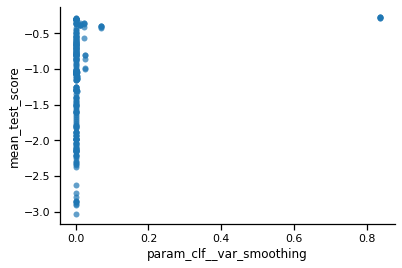

<AxesSubplot:xlabel='param_select_features__estimator__base_estimator__ccp_alpha', ylabel='mean_test_score'>

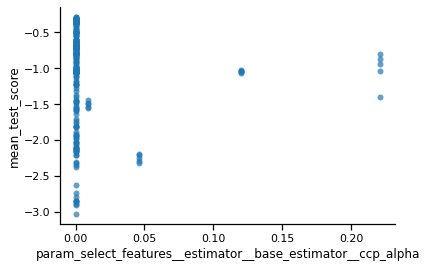

<AxesSubplot:xlabel='param_select_features__estimator__base_estimator__max_depth', ylabel='mean_test_score'>

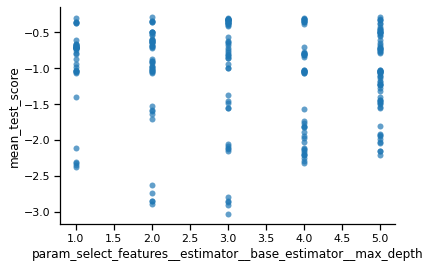

<AxesSubplot:xlabel='param_select_features__estimator__base_estimator__max_leaf_nodes', ylabel='mean_test_score'>

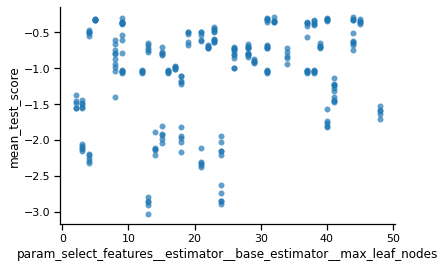

<AxesSubplot:xlabel='param_select_features__estimator__base_estimator__min_impurity_decrease', ylabel='mean_test_score'>

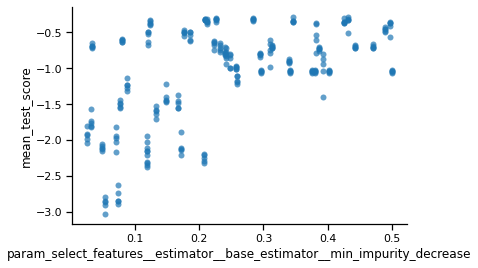

<AxesSubplot:xlabel='param_select_features__estimator__base_estimator__min_samples_leaf', ylabel='mean_test_score'>

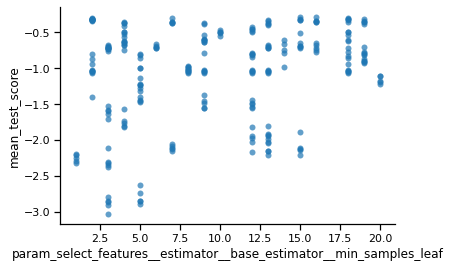

<AxesSubplot:xlabel='param_select_features__estimator__base_estimator__min_samples_split', ylabel='mean_test_score'>

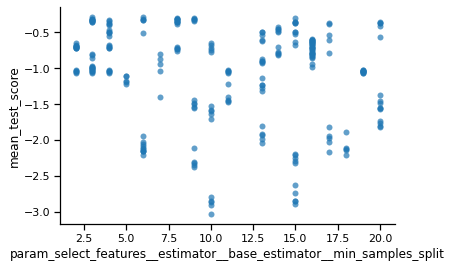

<AxesSubplot:xlabel='param_select_features__estimator__base_estimator__min_weight_fraction_leaf', ylabel='mean_test_score'>

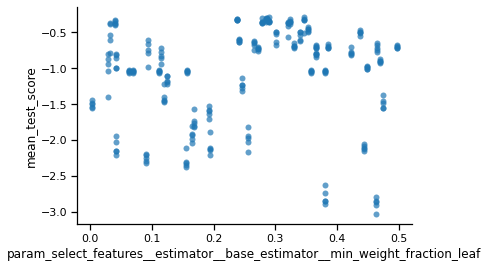

<AxesSubplot:xlabel='param_select_features__estimator__learning_rate', ylabel='mean_test_score'>

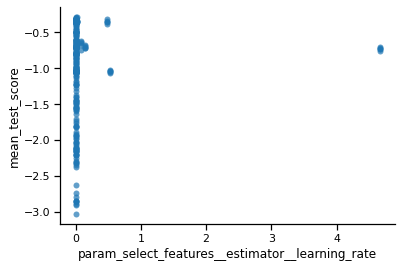

<AxesSubplot:xlabel='param_select_features__estimator__n_estimators', ylabel='mean_test_score'>

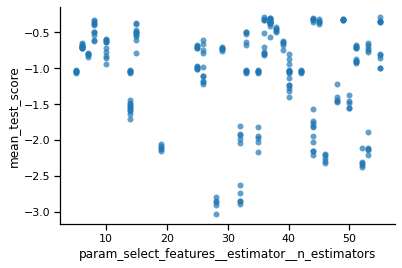

<AxesSubplot:xlabel='param_clf__base_estimator__var_smoothing', ylabel='mean_test_score'>

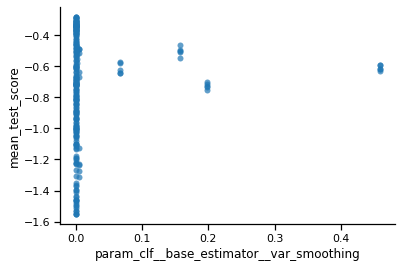

<AxesSubplot:xlabel='param_clf__max_features', ylabel='mean_test_score'>

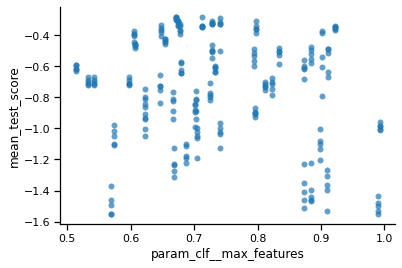

<AxesSubplot:xlabel='param_clf__max_samples', ylabel='mean_test_score'>

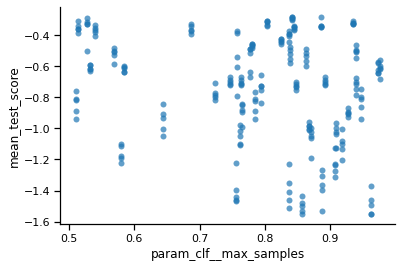

<AxesSubplot:xlabel='param_clf__n_estimators', ylabel='mean_test_score'>

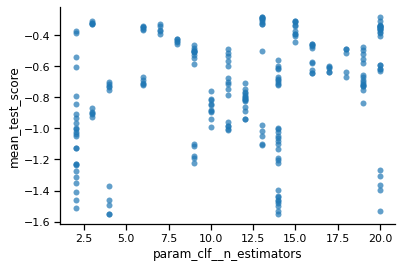

time: 2.51 s


In [28]:
for numcol in numcols:
    sns.scatterplot(
        data=cv_df,
        x=cv_df[numcol],
        y=cv_df.mean_test_score,
        linewidth=0,
        alpha=0.7,
        palette="colorblind",
    )
    sns.despine(top=True, right=True)
    plt.show()

<AxesSubplot:xlabel='param_clf__var_smoothing', ylabel='mean_test_score'>

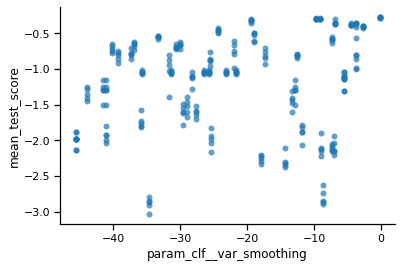

<AxesSubplot:xlabel='param_select_features__estimator__base_estimator__ccp_alpha', ylabel='mean_test_score'>

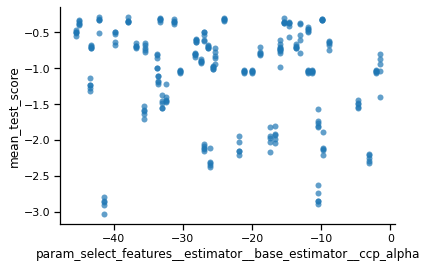

<AxesSubplot:xlabel='param_select_features__estimator__base_estimator__max_depth', ylabel='mean_test_score'>

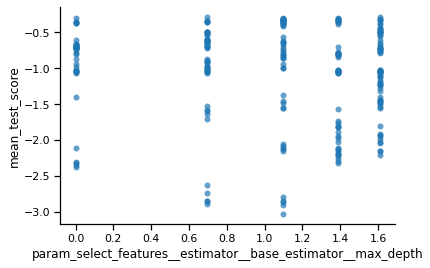

<AxesSubplot:xlabel='param_select_features__estimator__base_estimator__max_leaf_nodes', ylabel='mean_test_score'>

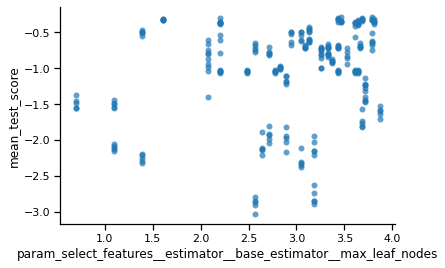

<AxesSubplot:xlabel='param_select_features__estimator__base_estimator__min_impurity_decrease', ylabel='mean_test_score'>

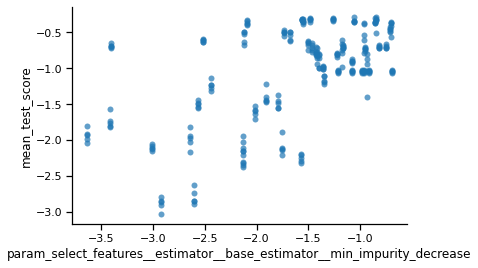

<AxesSubplot:xlabel='param_select_features__estimator__base_estimator__min_samples_leaf', ylabel='mean_test_score'>

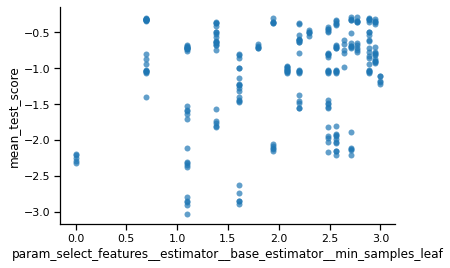

<AxesSubplot:xlabel='param_select_features__estimator__base_estimator__min_samples_split', ylabel='mean_test_score'>

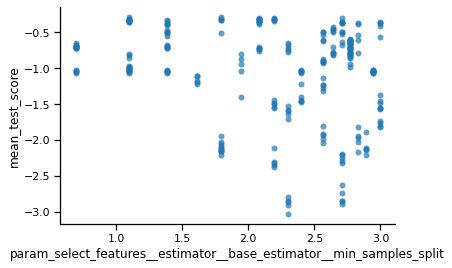

<AxesSubplot:xlabel='param_select_features__estimator__base_estimator__min_weight_fraction_leaf', ylabel='mean_test_score'>

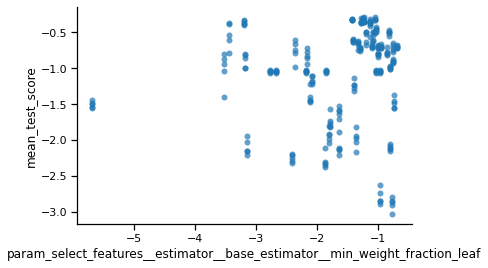

<AxesSubplot:xlabel='param_select_features__estimator__learning_rate', ylabel='mean_test_score'>

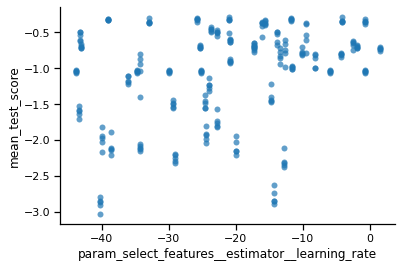

<AxesSubplot:xlabel='param_select_features__estimator__n_estimators', ylabel='mean_test_score'>

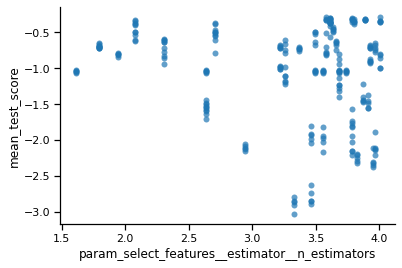

<AxesSubplot:xlabel='param_clf__base_estimator__var_smoothing', ylabel='mean_test_score'>

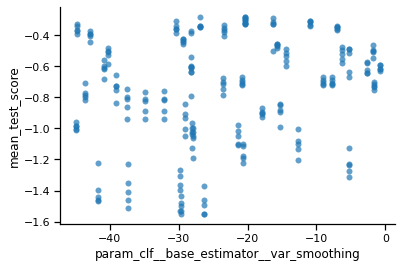

<AxesSubplot:xlabel='param_clf__max_features', ylabel='mean_test_score'>

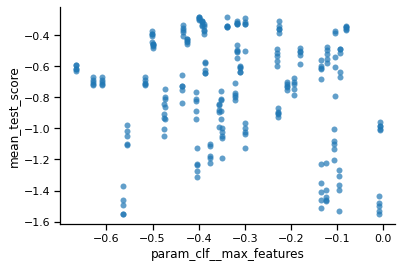

<AxesSubplot:xlabel='param_clf__max_samples', ylabel='mean_test_score'>

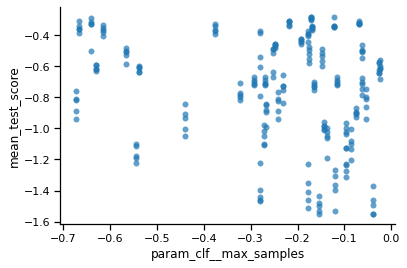

<AxesSubplot:xlabel='param_clf__n_estimators', ylabel='mean_test_score'>

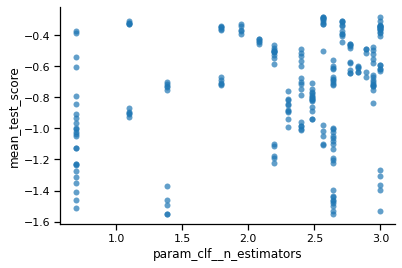

time: 2.29 s


In [30]:
for numcol in numcols:
    sns.scatterplot(
        data=cv_df,
        x=np.log(cv_df[numcol]),
        y=cv_df.mean_test_score,
        linewidth=0,
        alpha=0.7,
        palette="colorblind",
    )
    sns.despine(top=True, right=True)
    plt.show()

<AxesSubplot:xlabel='mean_test_score', ylabel='Count'>

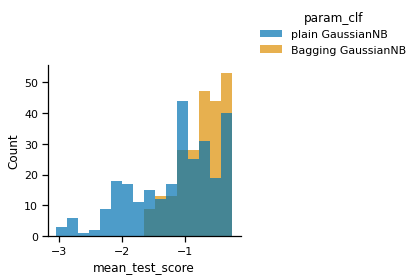

<AxesSubplot:xlabel='mean_test_score', ylabel='Count'>

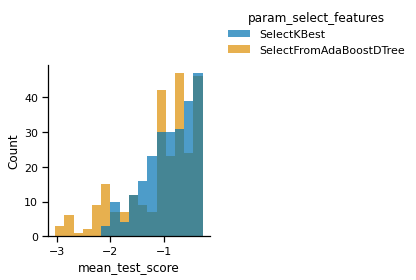

<AxesSubplot:xlabel='mean_test_score', ylabel='Count'>

C:\Users\michen\AppData\Local\Temp/ipykernel_19252/3912084730.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


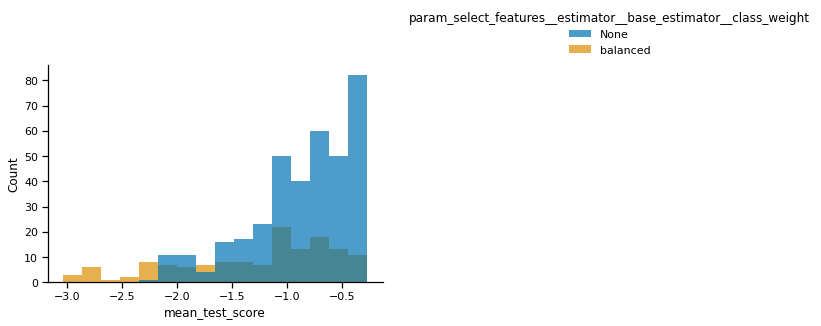

<AxesSubplot:xlabel='mean_test_score', ylabel='Count'>

C:\Users\michen\AppData\Local\Temp/ipykernel_19252/3912084730.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


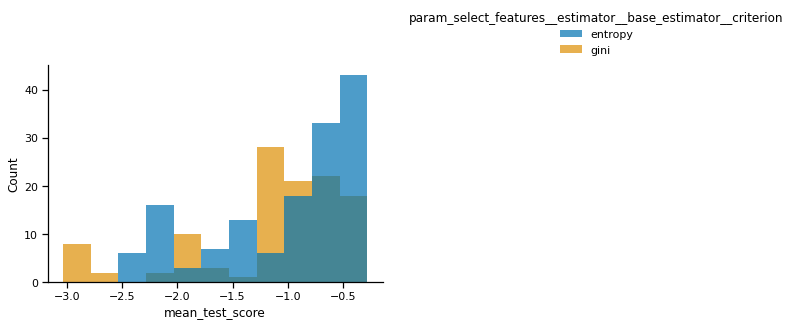

<AxesSubplot:xlabel='mean_test_score', ylabel='Count'>

C:\Users\michen\AppData\Local\Temp/ipykernel_19252/3912084730.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


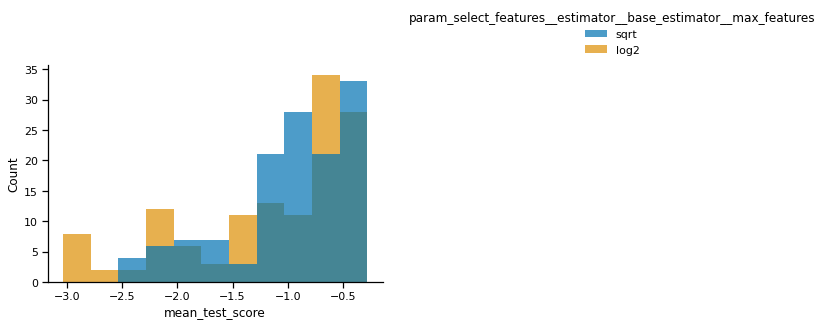

<AxesSubplot:xlabel='mean_test_score', ylabel='Count'>

C:\Users\michen\AppData\Local\Temp/ipykernel_19252/3912084730.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


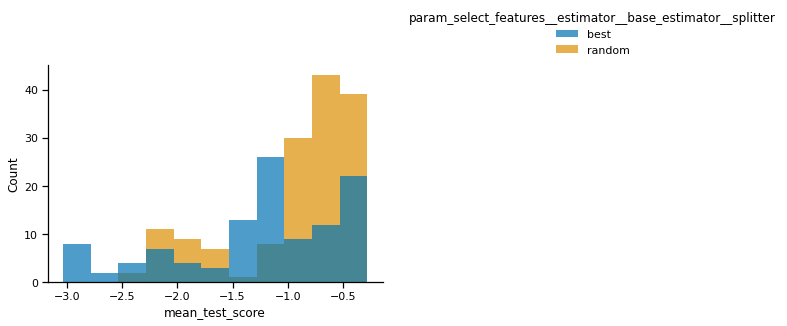

<AxesSubplot:xlabel='mean_test_score', ylabel='Count'>

C:\Users\michen\AppData\Local\Temp/ipykernel_19252/3912084730.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


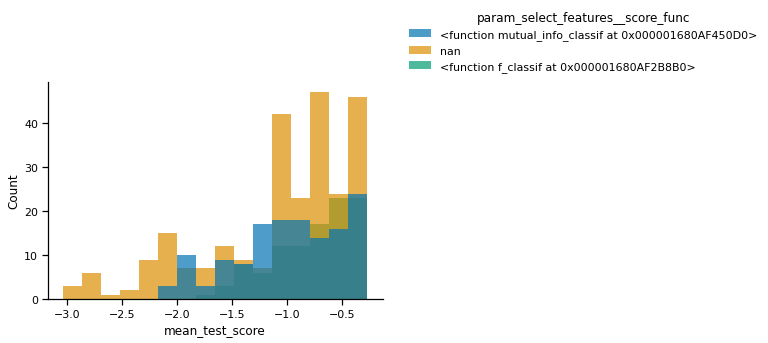

<AxesSubplot:xlabel='mean_test_score', ylabel='Count'>

C:\Users\michen\AppData\Local\Temp/ipykernel_19252/3912084730.py:47: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


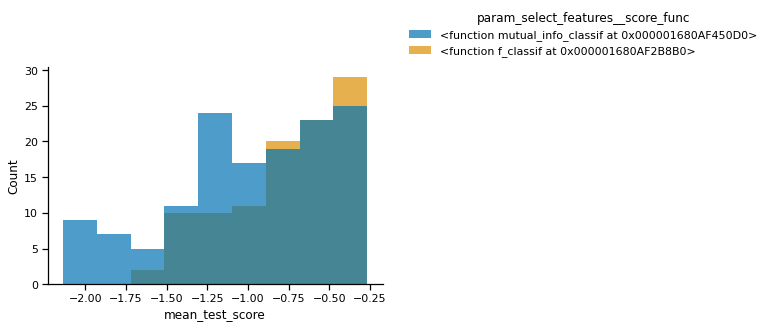

time: 2.27 s


In [67]:
cv_df = load_cv_df().reset_index(drop=True)
class_weight = "param_select_features__estimator__base_estimator__class_weight"
cv_df.loc[:, class_weight] = cv_df.loc[:, class_weight].astype(str)
cv_df.loc[cv_df.param_clf.str.contains("Bagging"), "param_clf"] = "Bagging GaussianNB"
cv_df.loc[~cv_df.param_clf.str.contains("Bagging"), "param_clf"] = "plain GaussianNB"
cv_df.loc[
    cv_df.param_select_features.str.contains("SelectKBest"), "param_select_features"
] = "SelectKBest"
cv_df.loc[
    ~cv_df.param_select_features.str.contains("SelectKBest"), "param_select_features"
] = "SelectFromAdaBoostDTree"
for catcol in catcols:
    sns.histplot(
        data=cv_df,
        x=cv_df.mean_test_score,
        hue=cv_df.loc[:, catcol],
        linewidth=0,
        alpha=0.7,
        palette="colorblind",
    )
    sns.despine(top=True, right=True)
    sns.move_legend(
        plt.gca(),
        "lower left",
        bbox_to_anchor=(1.05, 1),
        frameon=False,
    )
    plt.tight_layout()
    plt.show()

cv_df = cv_df.loc[cv_df.param_select_features__score_func != "nan"]
sns.histplot(
    data=cv_df,
    x=cv_df.mean_test_score,
    hue=cv_df.loc[:, "param_select_features__score_func"],
    linewidth=0,
    alpha=0.7,
    palette="colorblind",
)
sns.despine(top=True, right=True)
sns.move_legend(
    plt.gca(),
    "lower left",
    bbox_to_anchor=(1.05, 1),
    frameon=False,
)
plt.tight_layout()
plt.show()

# Discussion

Although best performance may not be achieved through naively including all crafted features, structural multicollinearity doesn't seem to be too much of a problem.

Resampling is an expensive procedure to tune. We may have to focus on other parts of the pipeline first. After those configurations are settled, we can try maybe one or two resampling approaches and hope one of them boosts performance. Again, it will be difficult to find the best method; rather, we should aim to find a good method.

The inner CV hyperparameter search likely overfits because of speaker leakage. However, there is no speaker leakage in the outer folds. Although the cross-validated scores should be reliable, the hyperparameters found may not be optimal. This will be less of an issue when training the full prototype, however, as hyperparameter search will be cross-validated over the entire dataset rather than a single prepared (no speaker leakage) fold at a time (non-nested hyperparameter search).

For SelectKBest, < 20 features may be appropriate. SelectFromModel is only efficacious with certain models. The best accuracy is better than ExtraTrees, but ExtraTrees actually got higher AUROC. A uniform sampling distribution may be better for var_smoothing.

Some of the graphics are overplotted.

AdaBoost may be good for feature selection.

var_smoothing can be set to < 0.75

In [ ]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

[^top](#Contents)